In [67]:
# Derived from:
#     https://www.axonlab.org/hcph-sops/data-management/eyetrack-qc

In [68]:
# Load the autoreload extension
%load_ext autoreload
# Set autoreload to update the modules every time before executing a new line of code
%autoreload 2

%matplotlib inline
from pathlib import Path
import json
import ppjson
from importlib import reload  # For debugging purposes

import numpy as np
import pandas as pd

import eyetrackingrun as et

from IPython.display import HTML
from matplotlib import animation
from matplotlib.animation import FuncAnimation, PillowWriter
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

from write_bids_yiwei import EyeTrackingRun, write_bids, write_bids_from_df

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [69]:
BIDS_PATH = Path("D:\\Eye_Dataset\\Sub003\\230928_anatomical_MREYE_study\\ET_EDF")
FILE_NAME ='OT2'
session = "004" #can be a string to be defined when required
tsv_name = f"{FILE_NAME}.tsv.gz"
gif_name = f'{FILE_NAME}.gif'


In [70]:
# Read in tsv.gz file
# Naming convension can be modified later
# recording_file = BIDS_PATH / "sub-001" / f"ses-{session}" / "dwi" / f"sub-001_ses-{session}_acq-highres_dir-RL_recording-eyetrack_physio.tsv.gz"
recording_file = BIDS_PATH / tsv_name
print(f'recording_file: {recording_file}')
recording = pd.read_csv(
    recording_file,
#     sep=r"\s+",
    sep="\t",
    na_values="n/a",
)
print(recording.head())

metadata = json.loads((
    recording_file.parent
    / recording_file.name.replace(".tsv.gz", ".json")
).read_text())
print(f'meta_data: {metadata}')

recording_file: D:\Eye_Dataset\Sub003\230928_anatomical_MREYE_study\ET_EDF\OT2.tsv.gz
   Unnamed: 0  eye1_x_coordinate  eye1_y_coordinate  eye1_pupil_size  \
0           0         748.200012                NaN           3474.0   
1           1         748.400024                NaN           3471.0   
2           2         750.200012                NaN           3472.0   
3           3         752.299988                NaN           3478.0   
4           4         752.700012                NaN           3489.0   

   eye1_pupil_x_coordinate  eye1_pupil_y_coordinate  eye1_href_x_coordinate  \
0                    -66.0                   -413.0                  3436.0   
1                    -63.0                   -417.0                  3438.0   
2                    -54.0                   -397.0                  3456.0   
3                    -46.0                   -373.0                  3477.0   
4                    -48.0                   -358.0                  3480.0   

   eye

# Metadata and calibration

The DWI run of our protocol is the first time the eye-tracker is employed. Therefore, we always run a calibration before it is started. As a result, we will typically see the metadata corresponding to calibration on this particular run.

Now, let's print out the contents of the BIDS' sidecar JSON corresponding to the DWI in this session.

In [71]:
# print(
#     json.dumps(metadata, sort_keys=True, indent=2, cls=ppjson.CompactJSONEncoder)
# )

# Compared to the data in the link, we don;t have the following information
# "saccade": {
#     "Description": "Continuous recording of saccade events calculated by the eyetracking device (one indicates the saccade is active)."
#   },
#   "screen_ppdeg_x_coordinate": { "Description": "Screen pixels per degree (x-coordinate).", "Units": "pixels/degree" },
#   "screen_ppdeg_y_coordinate": { "Description": "Screen pixels per degree (y-coordinate).", "Units": "pixels/degree" },
#   "timestamp": { "Description": "Eye-tracker timestamp of the sampled recorded eye.", "Units": "a.u." },
#   "x_coordinate": { "Description": "Gaze position x-coordinate of the recorded eye.", "Units": "pixel" },
#   "y_coordinate": { "Description": "Gaze position y-coordinate of the recorded eye.", "Units": "pixel" }
# }

In [72]:
print(recording)

        Unnamed: 0  eye1_x_coordinate  eye1_y_coordinate  eye1_pupil_size  \
0                0         748.200012                NaN           3474.0   
1                1         748.400024                NaN           3471.0   
2                2         750.200012                NaN           3472.0   
3                3         752.299988                NaN           3478.0   
4                4         752.700012                NaN           3489.0   
...            ...                ...                ...              ...   
738942      738942         496.100006         268.399994           3213.0   
738943      738943         495.799988         267.299988           3215.0   
738944      738944         496.799988         266.600006           3220.0   
738945      738945         498.100006         265.500000           3224.0   
738946      738946         499.299988         265.100006           3229.0   

        eye1_pupil_x_coordinate  eye1_pupil_y_coordinate  \
0              

In [73]:
t_axis = (
    recording.timestamp.values - recording.timestamp[0]
) / metadata["SamplingFrequency"]

In [74]:
print(metadata["Columns"])
recording = recording.rename(
        columns={
            f"eye1_pupil_size": f"pupil_size",
            f"eye1_fixation'": f"fixation",
            f"eye1_saccade": f"saccade",
            f"eye1_blink": f"blink",
            f"eye1_x_coordinate": f"x_coordinate", 
            f"eye1_y_coordinate": f"y_coordinate"         
        }
    )

metadata["Columns"] = recording.columns.tolist()
# print(metadata["Columns"])

['eye1_x_coordinate', 'eye1_y_coordinate', 'eye1_pupil_size', 'eye1_pupil_x_coordinate', 'eye1_pupil_y_coordinate', 'eye1_href_x_coordinate', 'eye1_href_y_coordinate', 'fast_raw_x_velocity', 'screen_ppdeg_x_coordinate', 'screen_ppdeg_y_coordinate', 'timestamp', 'eye1_fixation', 'eye1_saccade', 'eye1_blink']


(100.0, 150.0)

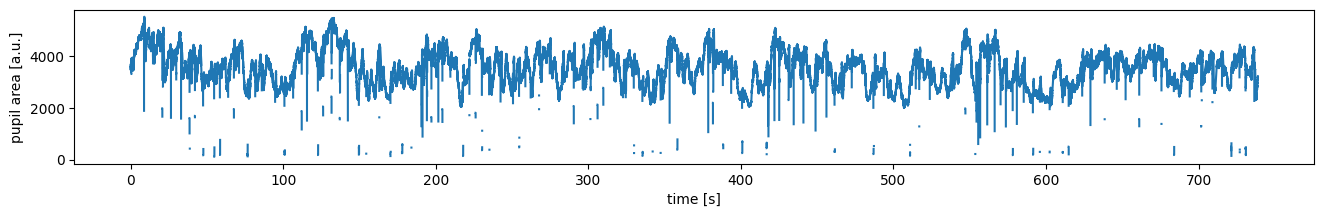

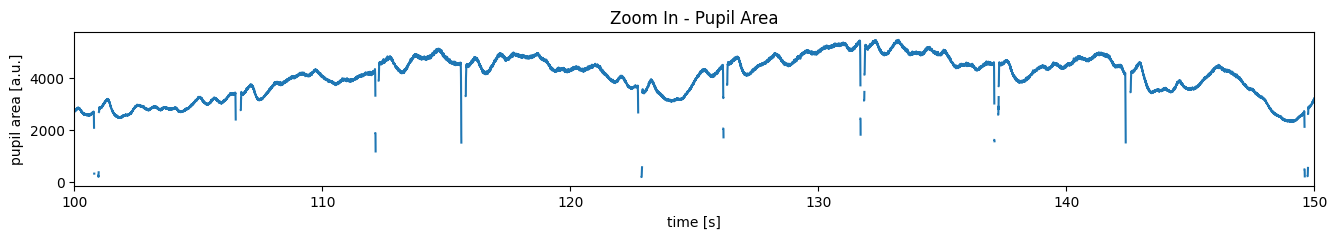

In [75]:
fig = plt.figure(figsize=(16, 2))
plt.plot(
    t_axis,
    recording["pupil_size"].values,
)

plt.xlabel("time [s]")
plt.ylabel("pupil area [a.u.]");

fig = plt.figure(figsize=(16, 2))
plt.plot(
    t_axis,
    recording["pupil_size"].values,
)
plt.title("Zoom In - Pupil Area")
plt.xlabel("time [s]")
plt.ylabel("pupil area [a.u.]")
# JB1 (100, 150)
plt.xlim((100, 150))

(100.0, 150.0)

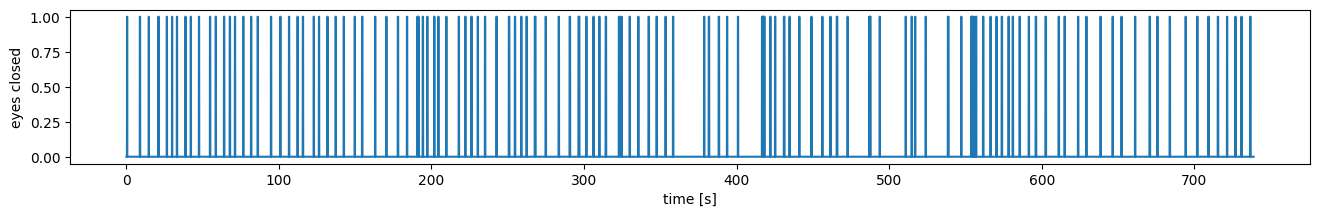

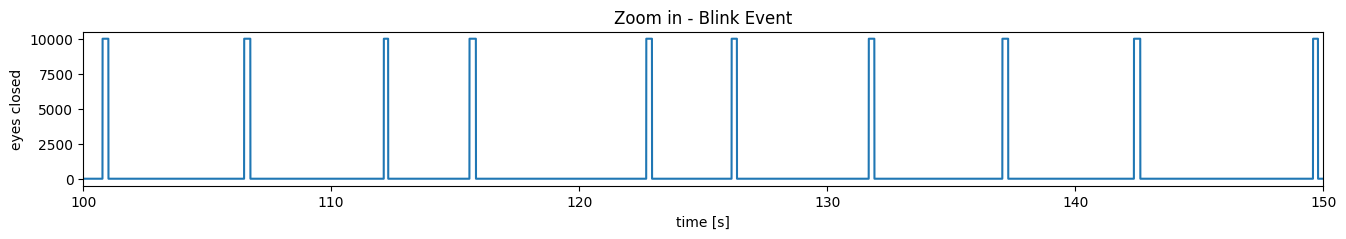

In [76]:
fig = plt.figure(figsize=(16, 2))
plt.plot(
    t_axis,
    recording["blink"].values,
)

plt.xlabel("time [s]")
plt.ylabel("eyes closed");

fig = plt.figure(figsize=(16, 2))
plt.plot(
    t_axis,
    recording["blink"].values * 10000,
)
plt.xlabel("time [s]")
plt.ylabel("eyes closed")
plt.title("Zoom in - Blink Event")
plt.xlim((100, 150))

At this time, since blinking is detected, we cannot get clear pupil area ?


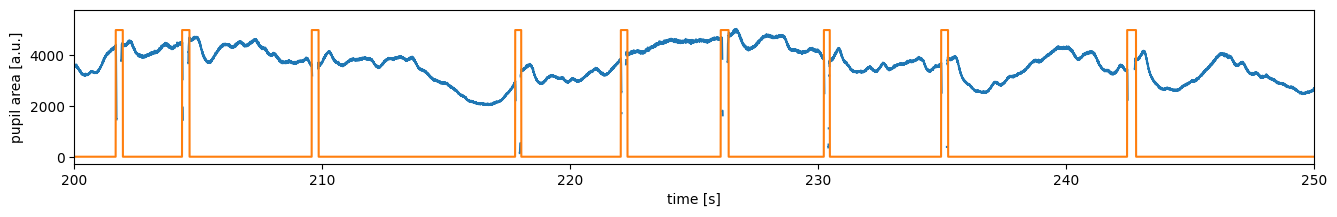

In [77]:
fig = plt.figure(figsize=(16, 2))

plt.plot(
    t_axis,
    recording["pupil_size"].values,
)

plt.plot(
    t_axis,
    recording["blink"].values * 5000,
)

plt.xlabel("time [s]")
plt.ylabel("pupil area [a.u.]")
plt.xlim((200, 250))

print(f'At this time, since blinking is detected, we cannot get clear pupil area ?')

Now we can clean up the pupil area time series by removing data while the eye was closed to eliminate the artifact caused by blinking.

(200.0, 240.0)

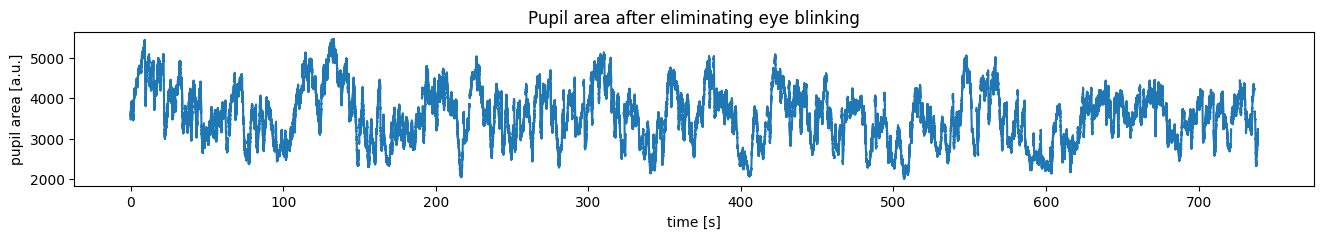

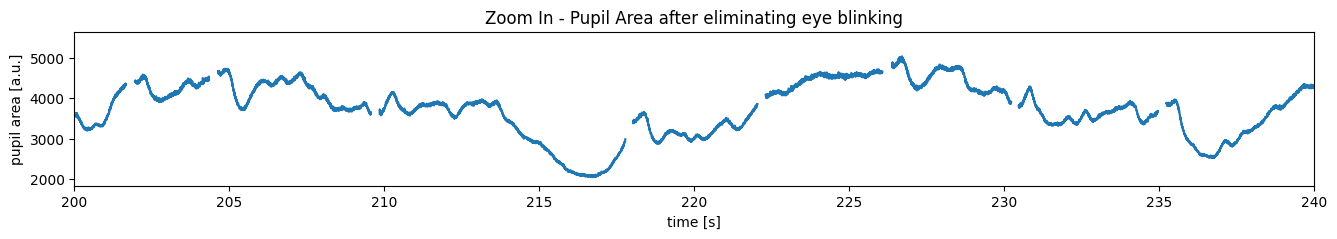

In [82]:
pupil_area = recording["pupil_size"].values
pupil_area[recording["blink"] > 0] = np.nan

fig = plt.figure(figsize=(16, 2))

plt.plot(
    t_axis,
    recording["pupil_size"].values,
)
plt.title("Pupil area after eliminating eye blinking")
plt.xlabel("time [s]")
plt.ylabel("pupil area [a.u.]");

fig = plt.figure(figsize=(16, 2))
plt.plot(
    t_axis,
    recording["pupil_size"].values,
)
plt.title("Zoom In - Pupil Area after eliminating eye blinking")
plt.xlabel("time [s]")
plt.ylabel("pupil area [a.u.]")
plt.xlim((200, 240))

        x_coordinate  y_coordinate
0         748.200012           NaN
1         748.400024           NaN
2         750.200012           NaN
3         752.299988           NaN
4         752.700012           NaN
...              ...           ...
738942    496.100006    268.399994
738943    495.799988    267.299988
738944    496.799988    266.600006
738945    498.100006    265.500000
738946    499.299988    265.100006

[738947 rows x 2 columns]
len of coor_data 704962 should be equal to len of coor_recording 704962
After eliminating blinking: 
len of coor_data 697608 should be equal to len of coor_recording 697608


<AxesSubplot:title={'center':'The gaze from the beginning to the end'}, xlabel='x coordinate [pixels]', ylabel='y coordinate [pixels]'>

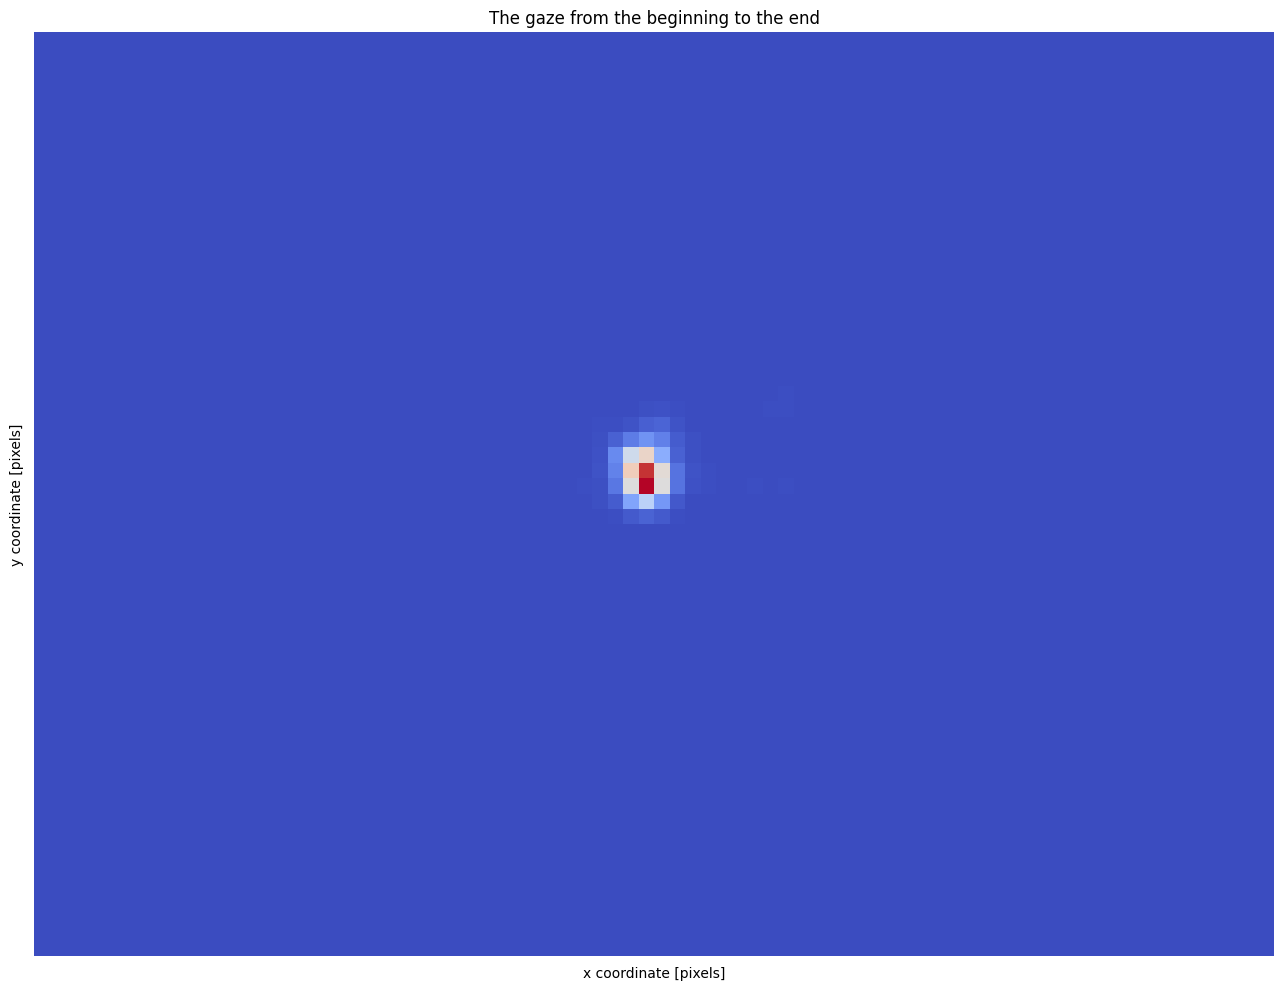

In [83]:
import plot
size = (
    metadata["ScreenAOIDefinition"][1][1],
    metadata["ScreenAOIDefinition"][1][3],
)

coor_data = recording[["x_coordinate", "y_coordinate"]]
print(coor_data)

coor_data = coor_data[coor_data.x_coordinate.notna() & coor_data.y_coordinate.notna()]
coor_recording = recording[recording.x_coordinate.notna() & recording.y_coordinate.notna()]
coor_data.reset_index(drop=True, inplace=True)
coor_recording.reset_index(drop=True, inplace=True)
print(f'len of coor_data {len(coor_data)} should be equal to len of coor_recording {len(coor_recording)}')

coor_data = coor_data[coor_recording.blink < 1]
coor_recording = coor_recording[coor_recording.blink < 1]
print(f'After eliminating blinking: \nlen of coor_data {len(coor_data)} should be equal to len of coor_recording {len(coor_recording)}')
plot.plot_heatmap_coordinate(coor_data, density=False, screen_size=size, 
                             title='The gaze from the beginning to the end')

Text(0, 0.5, 'y coordinate [px]')

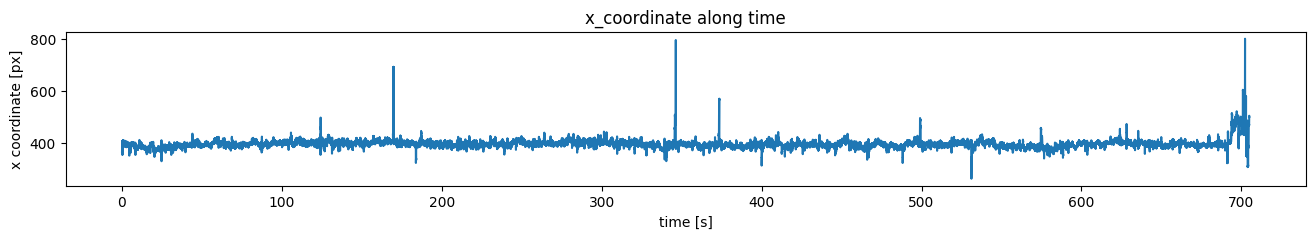

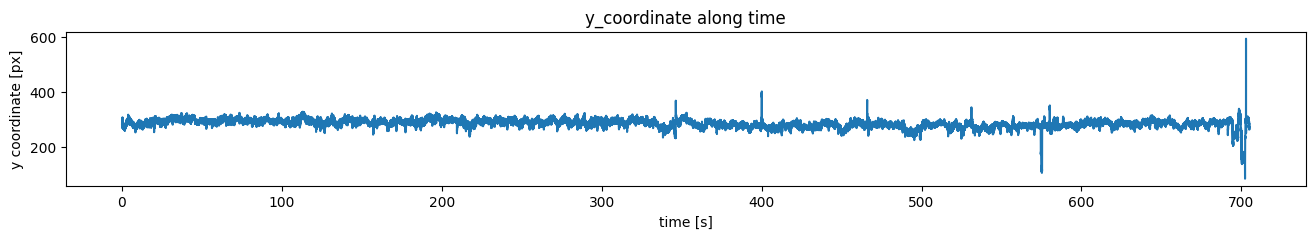

In [84]:
# Find the gaze period

t_axis_xy = (
    coor_data.index 
) / metadata["SamplingFrequency"]

# x coordinate
fig = plt.figure(figsize=(16, 2))

plt.plot(
    t_axis_xy,
    coor_data["x_coordinate"].values,
)
plt.title("x_coordinate along time")
plt.xlabel("time [s]")
plt.ylabel("x coordinate [px]")

# y coordinate
fig = plt.figure(figsize=(16, 2))

plt.plot(
    t_axis_xy,
    coor_data["y_coordinate"].values,
)
plt.title("y_coordinate along time")
plt.xlabel("time [s]")
plt.ylabel("y coordinate [px]")


Text(0, 0.5, 'y coordinate [px]')

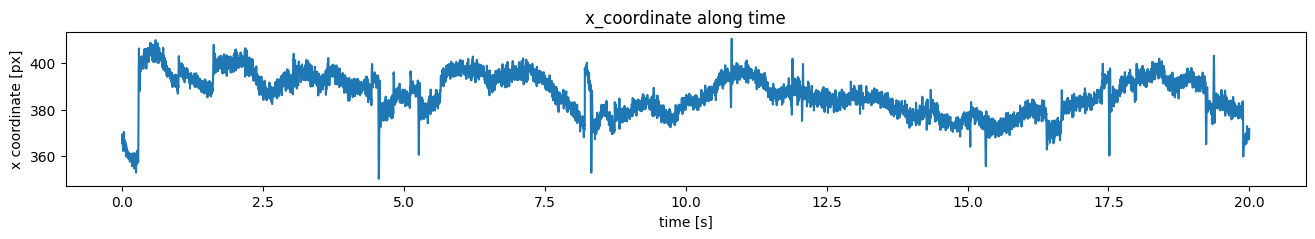

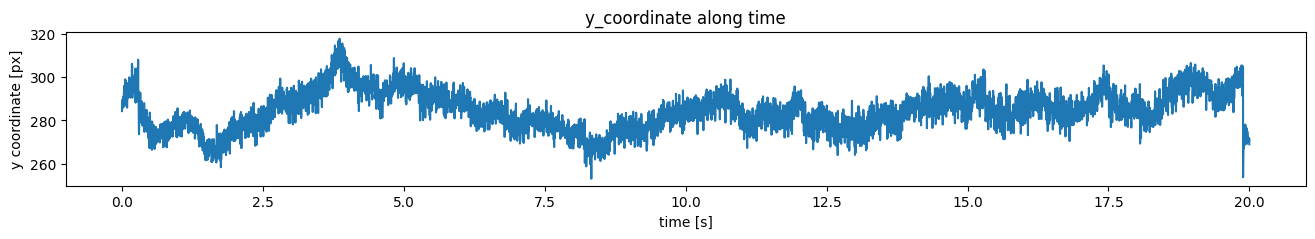

In [85]:
# Zoom in to find the period of gazing

duration = 20
start_sample = 0
end_sample = duration*metadata["SamplingFrequency"]
t_axis_xy = np.arange(start_sample, end_sample, 1)/metadata["SamplingFrequency"]

# x coordinate
fig = plt.figure(figsize=(16, 2))

plt.plot(
    t_axis_xy,
    coor_data["x_coordinate"].values[start_sample:end_sample],
)
plt.title("x_coordinate along time")
plt.xlabel("time [s]")
plt.ylabel("x coordinate [px]")

# y coordinate
fig = plt.figure(figsize=(16, 2))

plt.plot(
    t_axis_xy,
    coor_data["y_coordinate"].values[start_sample:end_sample],
)
plt.title(f"y_coordinate along time")
plt.xlabel("time [s]")
plt.ylabel("y coordinate [px]")


From the figure above,I did not find the salient gazing peroid. So I just plot the heat maps every 2,5 second

In [86]:
plot_one_by_one = False
if plot_one_by_one:
    # Zoom in to find the period of gazing
    plot_x_y_coor = False
    plot_heat_map = True

    duration = 600
    period = 100
    start_sample = int(10*metadata["SamplingFrequency"])
    end_sample = start_sample + int(duration*metadata["SamplingFrequency"])
    period_sample = int(period*metadata["SamplingFrequency"])

    for start_i in range(start_sample, end_sample, period_sample):
        t_axis_xy = np.arange(start_i, start_i+period_sample, 1)/metadata["SamplingFrequency"]
        if plot_x_y_coor:
            fig = plt.figure(figsize=(16, 2))
            # x coordinate
            plt.plot(
                t_axis_xy,
                coor_data["x_coordinate"].values[start_i:start_i+period_sample],
            )
            # y coordinate
            plt.plot(
                t_axis_xy,
                coor_data["y_coordinate"].values[start_i:start_i+period_sample],
            )
            plt.title("x_y_coordinate along time")
            plt.xlabel("time [s]")
            plt.ylabel("coordinate [px]");

        if plot_heat_map:
            sub_coor_data = coor_data.iloc[start_i:start_i+period_sample]
            plot.plot_heatmap_coordinate(sub_coor_data, 
                                         density=False, screen_size=size, 
                                         title='The gaze from the beginning to the end')



In [88]:
# Create an animation
save_animation = True
if save_animation:
    HEATMAP_ANIMATION_FIGURE_SIZE = (13, 13*size[1] /size[0])
    fig, ax = plt.subplots(figsize=HEATMAP_ANIMATION_FIGURE_SIZE, layout="tight")

    def update(frame):
        return plot.plot_heatmap_coordinate(frame,ax=ax,
                                             density=False, screen_size=size, 
                                             title='The gaze from the beginning to the end')


    duration = 700
    period = 10
    start_sample = int(10*metadata["SamplingFrequency"])
    end_sample = start_sample + int(duration*metadata["SamplingFrequency"])
    period_sample = int(period*metadata["SamplingFrequency"])
    num_frames = duration/period

    frames = []
    for start_i in range(start_sample, end_sample, period_sample):
        sub_coor_data = coor_data.iloc[start_i:start_i+period_sample]
        print(f'len of sub_coor_data:{len(sub_coor_data)}')
        frames.append(sub_coor_data)
        print(len(frames))

    interval = 1*1000
    anim = animation.FuncAnimation(
        fig, update, frames=frames, interval=interval, repeat=True, blit=False
    );
    # plt.show()
    plt.close('all');
    plt.clf();

    # Save the animation
    writer = PillowWriter(fps=1000/interval)
    gif_save_name = f'{duration}_{period}_'+gif_name
    gif_path = BIDS_PATH / gif_save_name
    anim.save(gif_path, writer=writer)
    print(f'The gif file is saved in {gif_path}')



len of sub_coor_data:10000
1
len of sub_coor_data:10000
2
len of sub_coor_data:10000
3
len of sub_coor_data:10000
4
len of sub_coor_data:10000
5
len of sub_coor_data:10000
6
len of sub_coor_data:10000
7
len of sub_coor_data:10000
8
len of sub_coor_data:10000
9
len of sub_coor_data:10000
10
len of sub_coor_data:10000
11
len of sub_coor_data:10000
12
len of sub_coor_data:10000
13
len of sub_coor_data:10000
14
len of sub_coor_data:10000
15
len of sub_coor_data:10000
16
len of sub_coor_data:10000
17
len of sub_coor_data:10000
18
len of sub_coor_data:10000
19
len of sub_coor_data:10000
20
len of sub_coor_data:10000
21
len of sub_coor_data:10000
22
len of sub_coor_data:10000
23
len of sub_coor_data:10000
24
len of sub_coor_data:10000
25
len of sub_coor_data:10000
26
len of sub_coor_data:10000
27
len of sub_coor_data:10000
28
len of sub_coor_data:10000
29
len of sub_coor_data:10000
30
len of sub_coor_data:10000
31
len of sub_coor_data:10000
32
len of sub_coor_data:10000
33
len of sub_coor_dat

<Figure size 640x480 with 0 Axes>

# Bene's Analysis Codes

In [91]:
# Analyze coor_data['x_coordinate'] and coor_data['y_coordinate']
# T1 acquisition lasts 6 minutes and 02 seconds, so (360 + 2)*1000 = 362 000
X_coord = coor_data["x_coordinate"].values
Y_coord = coor_data["y_coordinate"].values
print('After cleaning nan and eminating data affected by blinking')
print(f'The length of X coordinate data: {len(X_coord)}')
print(f'The length of Y coordinate data: {len(Y_coord)}')

After cleaning nan and eminating data affected by blinking
The length of X coordinate data: 697608
The length of Y coordinate data: 697608


In [92]:
metadata

{'AverageCalibrationError': [1.1],
 'CalibrationCount': 1,
 'CalibrationLog': [[4834491,
   '>>>>>>> CALIBRATION (HV5,P-CR) FOR RIGHT: <<<<<<<<<'],
  [4834492, 'Calibration points:'],
  [4834492, '-19.3, -32.4         0,      0'],
  [4834492, '-21.3, -49.5         0,  -2457'],
  [4834492, '-20.7, -17.4         0,   2457'],
  [4834492, '-44.7, -32.7     -3474,      0'],
  [4834492, '4.9, -33.6      3474,      0'],
  [4834492, 'eye check box: (L,R,T,B)\n\t  -50    10   -53   -14'],
  [4834492, 'href cal range: (L,R,T,B)\n\t-5211  5211 -3686  3686'],
  [4834492,
   'Cal coeff:(X=a+bx+cy+dxx+eyy,Y=f+gx+goaly+ixx+jyy)\n   5.882e-05  140.17 -0.58985  0.13493  0.9089 \n   4.4115e-05  2.9518  154.16  0.19219  0.60827'],
  [4834492, 'Prenormalize: offx, offy = -19.333 -32.431'],
  [4834492, 'Gains: cx:145.729 lx:137.333 rx:154.933'],
  [4834492, 'Gains: cy:201.385 ty:153.637 by:211.965'],
  [4834492, 'Resolution (upd) at screen center: X=1.8, Y=1.3'],
  [4834492, 'Gain Change Proportion: X: 0.1

In [93]:
# Distance head-coil projector 102 cm  - size of an emmetrope eye varies from 2.1 cm to 2.7 cm 
# (eye with a perfect vision)
# in mm - this is common to both horizontal and angular rotation. 24 is 2.4cm which is the size of eye
Cat1 =  24 + 1020
print('check here is the eye size is defined manually?  can we extract the info from metadata?')

# Depends on projector resolution, where 176px corresponds to 81.3 mm; 
# so the formula becomes (Recorded_traj_px - center in px)*81.3/176
# computation measures in mm， convert from px to mm
# Transfer from pixel domain to mm, and shift the displacement to the center of screen
Cat2_hor = abs(X_coord - 400)*81.3/176 ; 
Cat2_ver = abs(Y_coord - 300)*62/137; 

Hor_rot =  np.arctan(Cat2_hor/Cat1)
Ver_rot =  np.arctan(Cat2_ver/Cat1)

Disp_mm_eye_x =  np.tan(Hor_rot)*12 # 12: radius of the eye
Disp_mm_eye_y =  np.tan(Ver_rot)*12
print('check here is 12 defined manually?  can we extract the info from metadata?')


check here is the eye size is defined manually?  can we extract the info from metadata?
check here is 12 defined manually?  can we extract the info from metadata?


Text(0, 0.5, 'Vertical displacement [mm]')

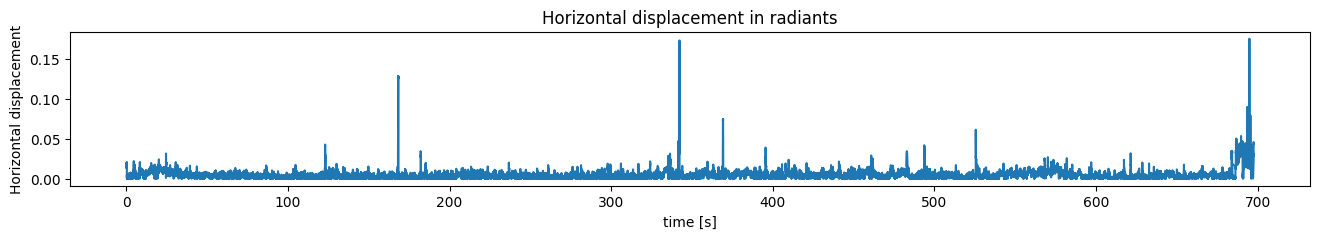

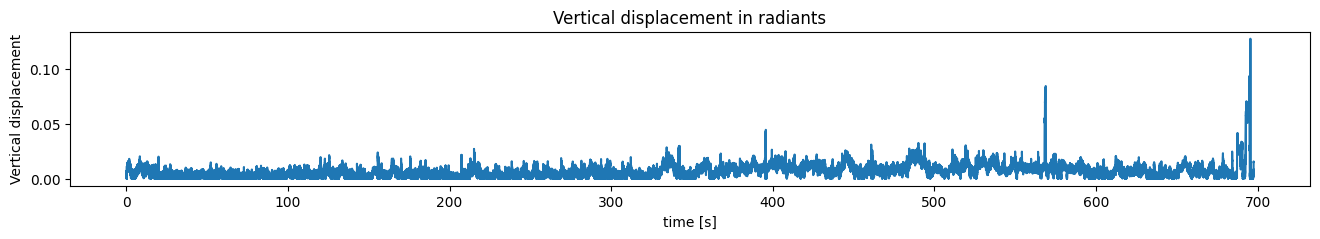

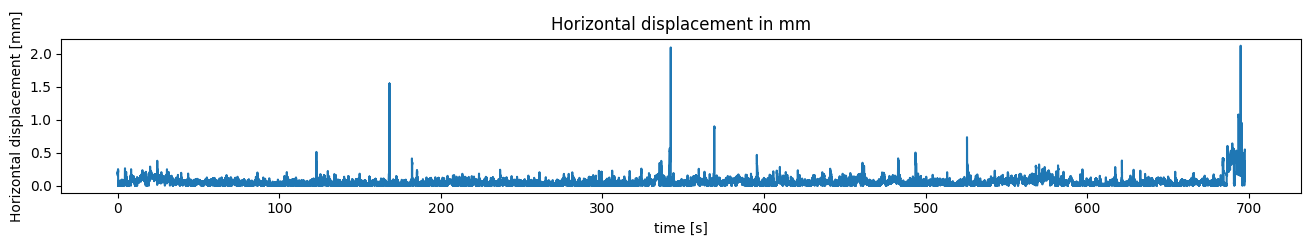

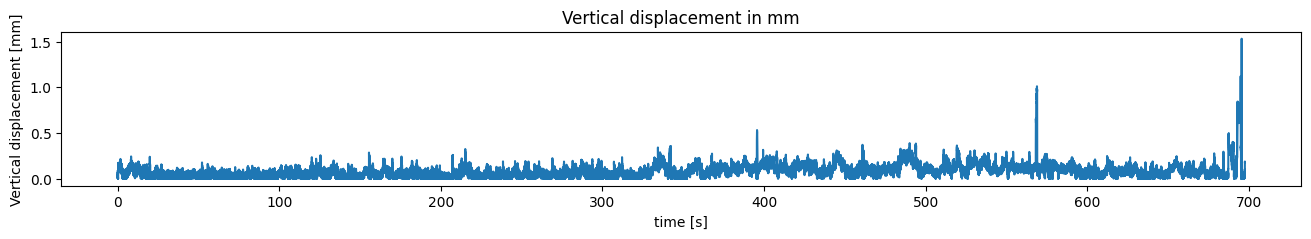

In [94]:
# plot the displacement in radiants
# Zoom in to find the period of gazing

duration = None
start_sample = 0
if duration == None:
    end_sample = len(Disp_mm_eye_x)
else:    
    end_sample = duration*metadata["SamplingFrequency"]
    
t_axis_xy = np.arange(start_sample, end_sample, 1)/metadata["SamplingFrequency"]


# x coordinate
fig = plt.figure(figsize=(16, 2))

plt.plot(
    t_axis_xy,
    Hor_rot[start_sample:end_sample],
)
plt.title('Horizontal displacement in radiants')
plt.xlabel("time [s]")
plt.ylabel("Horizontal displacement")

# y coordinate
fig = plt.figure(figsize=(16, 2))

plt.plot(
    t_axis_xy,
    Ver_rot[start_sample:end_sample],
)
plt.title(f"Vertical displacement in radiants")
plt.xlabel("time [s]")
plt.ylabel("Vertical displacement")


# x coordinate
fig = plt.figure(figsize=(16, 2))

plt.plot(
    t_axis_xy,
    Disp_mm_eye_x[start_sample:end_sample],
)
plt.title('Horizontal displacement in mm')
plt.xlabel("time [s]")
plt.ylabel("Horizontal displacement [mm]")

# y coordinate
fig = plt.figure(figsize=(16, 2))

plt.plot(
    t_axis_xy,
    Disp_mm_eye_y[start_sample:end_sample],
)
plt.title(f"Vertical displacement in mm")
plt.xlabel("time [s]")
plt.ylabel("Vertical displacement [mm]")


med_x 0.04141451198852891
med_y 0.06710291312878859
697608
697608


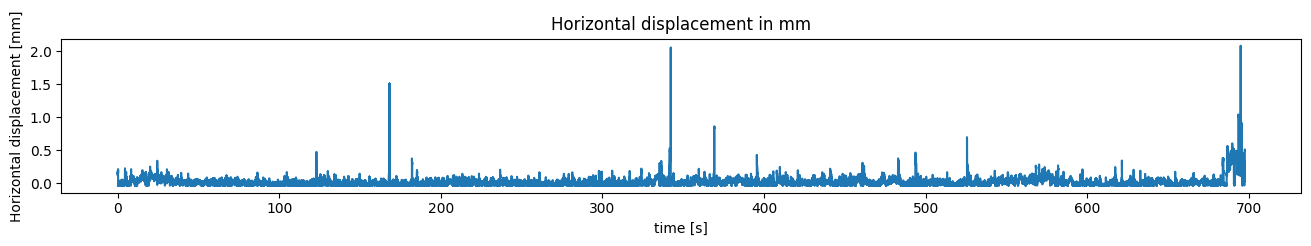

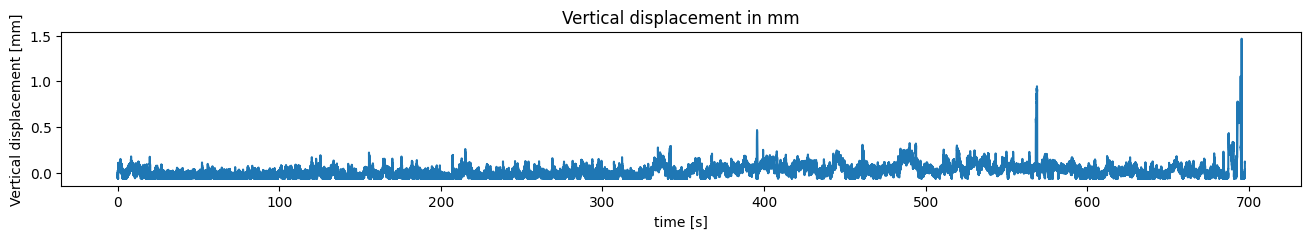

In [95]:
# %% Eliminate drift and recenter trajectories based on voxel size
# What is the meaning of voxel?

# I fixed this as the intra-voxel movement allowed, 
# 1/3 of the voxel size %0.5*std(Disp_mm_eye_x(Disp_mm_eye_x~=0));
med_x = np.median(Disp_mm_eye_x)
print(f'med_x {med_x}')
stand_x = 0.15 

med_y = np.median(Disp_mm_eye_y)
print(f'med_y {med_y}')
stand_y = 0.15
# 0.5*std(Disp_mm_eye_y);

# Subtract median
Disp_mm_eye_x_minus_mx = Disp_mm_eye_x - med_x
Disp_mm_eye_y_minus_my = Disp_mm_eye_y - med_y

fig = plt.figure(figsize=(16, 2))

plt.plot(
    t_axis_xy,
    Disp_mm_eye_x_minus_mx[start_sample:end_sample],
)
plt.title('Horizontal displacement in mm')
plt.xlabel("time [s]")
plt.ylabel("Horizontal displacement [mm]")


fig = plt.figure(figsize=(16, 2))
plt.plot(
    t_axis_xy,
    Disp_mm_eye_y_minus_my[start_sample:end_sample],
)
plt.title(f"Vertical displacement in mm")
plt.xlabel("time [s]")
plt.ylabel("Vertical displacement [mm]")


Ms_to_be_discarded = Disp_mm_eye_x_minus_mx

Ms_to_be_discarded_x_mask = ((Disp_mm_eye_x_minus_mx)>(stand_x) ) | ((Disp_mm_eye_x_minus_mx)<(-stand_x))
Ms_to_be_discarded_y_mask = ((Disp_mm_eye_y_minus_my)>(stand_y))| ((Disp_mm_eye_y_minus_my)<(-stand_y))
print(len(Ms_to_be_discarded_x_mask))
print(len(Ms_to_be_discarded_y_mask))


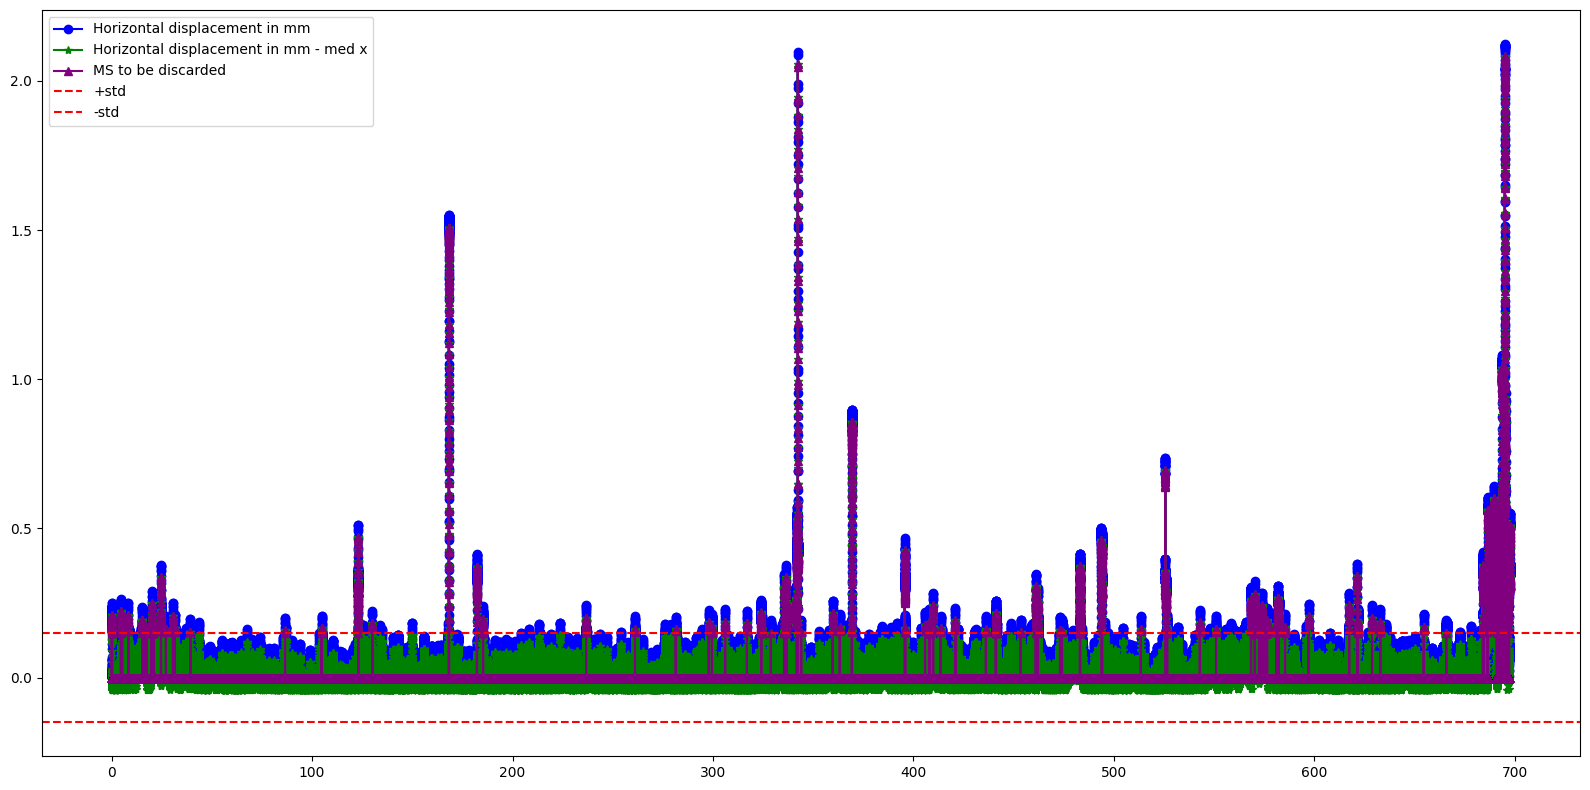

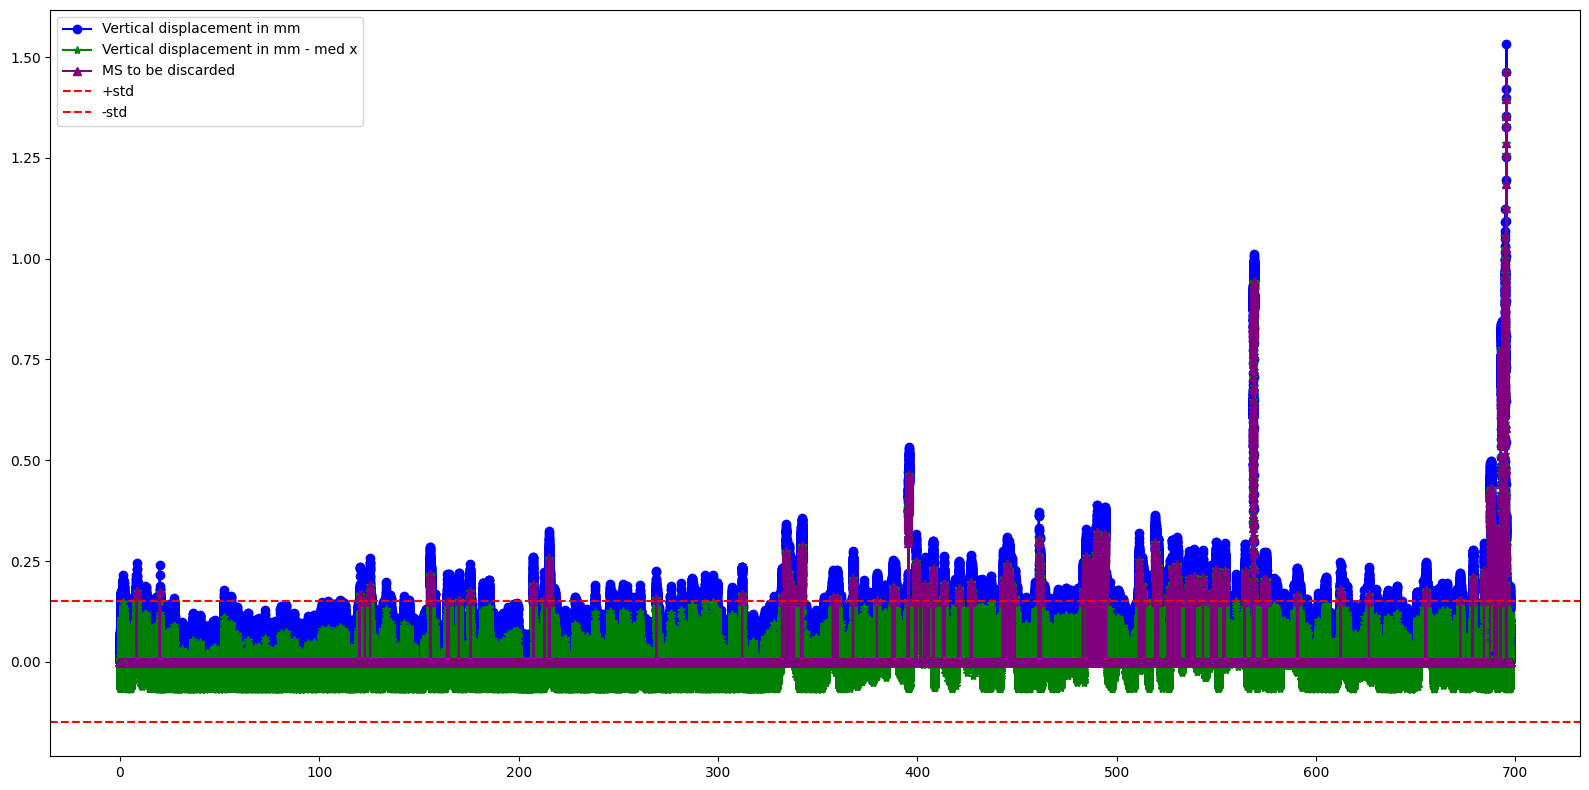

In [96]:
# Horizontal direction!!!!!
fig, ax= plt.subplots(figsize=(16, 8))
ax.plot(
    t_axis_xy,
    Disp_mm_eye_x[start_sample:end_sample],
    marker='o', color='blue',
    label="Horizontal displacement in mm"
)
ax.plot(
    t_axis_xy,
    Disp_mm_eye_x_minus_mx[start_sample:end_sample],
    marker='*', color='green',
    label='Horizontal displacement in mm - med x'
)

if len(Ms_to_be_discarded_x_mask) != 0:
    ax.plot(
        t_axis_xy,
        Disp_mm_eye_x_minus_mx[start_sample:end_sample] * Ms_to_be_discarded_x_mask[start_sample:end_sample],
        marker='^', color='purple',
        label= 'MS to be discarded'
    )

ax.axhline(y=stand_x, color='r', linestyle='--', label='+std')
ax.axhline(y=-stand_x, color='r', linestyle='--', label='-std')
ax.legend()
plt.tight_layout()

# Vertical direction!!!!!
fig, ax= plt.subplots(figsize=(16, 8))
ax.plot(
    t_axis_xy,
    Disp_mm_eye_y[start_sample:end_sample],
    marker='o', color='blue',
    label="Vertical displacement in mm"
)
ax.plot(
    t_axis_xy,
    Disp_mm_eye_y_minus_my[start_sample:end_sample],
    marker='*', color='green',
    label='Vertical displacement in mm - med x'
)

if len(Ms_to_be_discarded_y_mask) != 0:
    ax.plot(
        t_axis_xy,
        Disp_mm_eye_y_minus_my[start_sample:end_sample] * Ms_to_be_discarded_y_mask[start_sample:end_sample],
        marker='^', color='purple',
        label= 'MS to be discarded'
    )

ax.axhline(y=stand_y, color='r', linestyle='--', label='+std')
ax.axhline(y=-stand_y, color='r', linestyle='--', label='-std')
ax.legend()
plt.tight_layout()


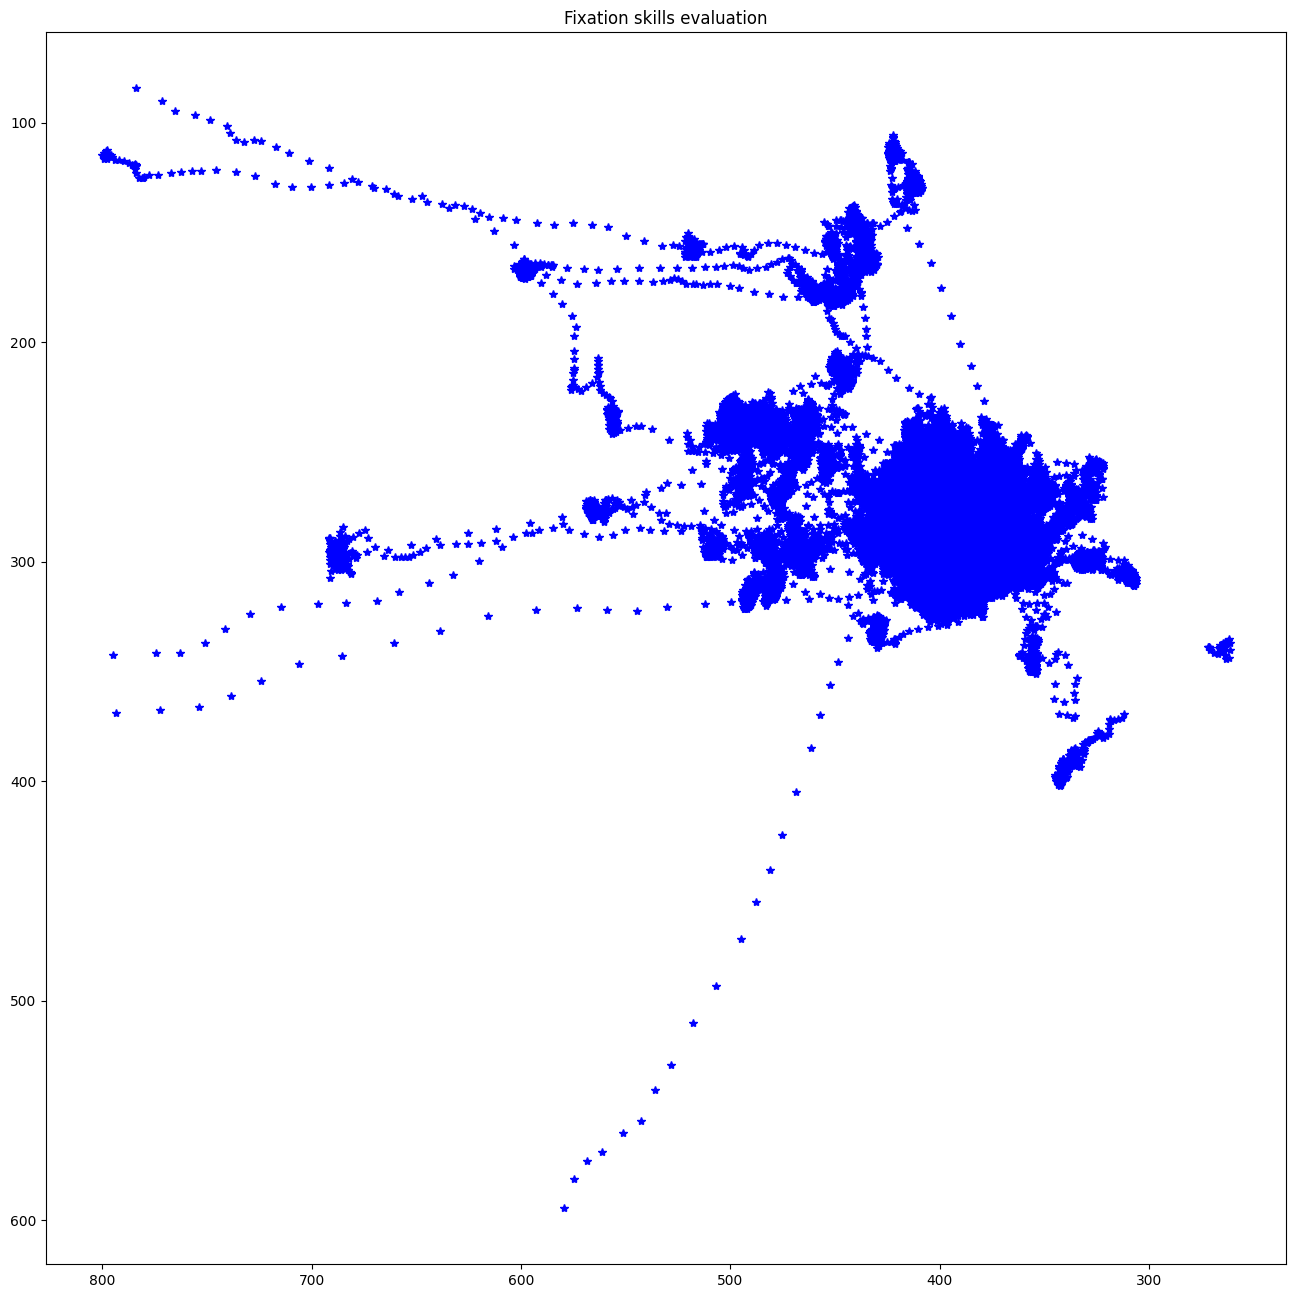

In [99]:
# Example data (replace with your actual data)
fig, ax= plt.subplots(figsize=(16, 16))


# Plot the data, flipping X coordinates and using dots as markers
plt.plot(X_coord, Y_coord, '*', color='blue')

# Set plot title
plt.title('Fixation skills evaluation')

# Reverse the direction of the Y-axis
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()


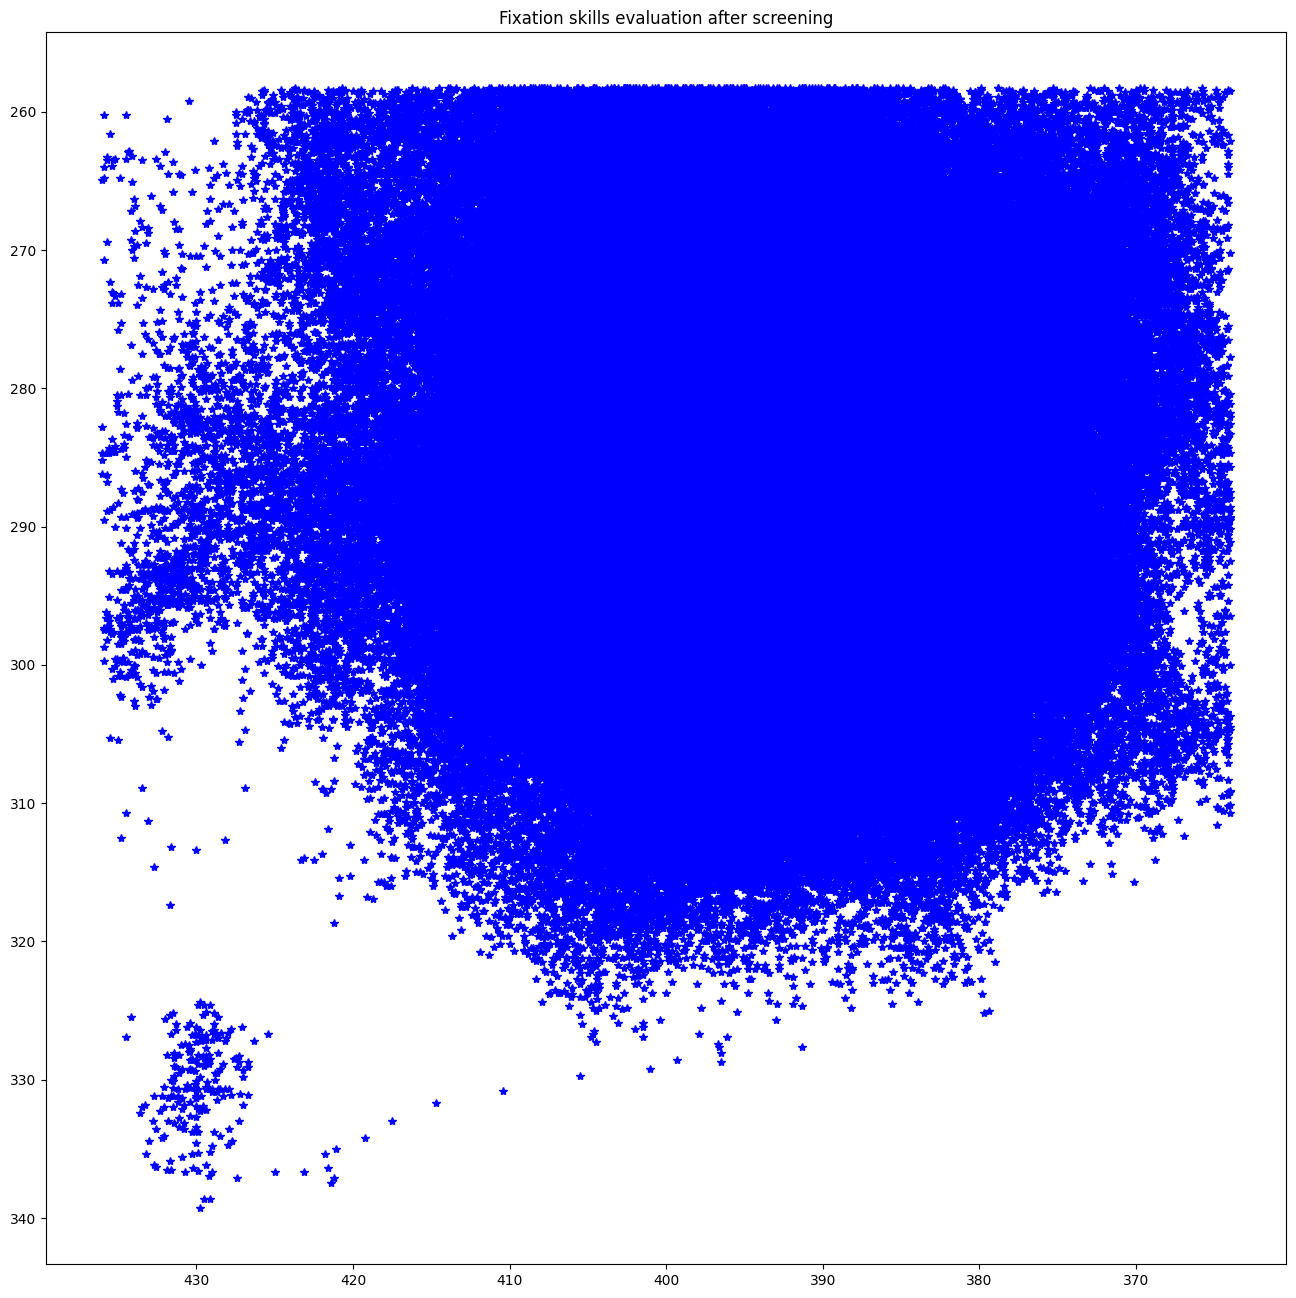

In [101]:
# Combined_mask = (~Ms_to_be_discarded_x_mask) & (~Ms_to_be_discarded_y_mask)
Combined_mask = ~(Ms_to_be_discarded_x_mask|Ms_to_be_discarded_y_mask)


filtered_X_coord = X_coord * Combined_mask
filtered_Y_coord = Y_coord * Combined_mask

zero_mask = (filtered_X_coord == 0) & (filtered_Y_coord == 0)
filtered_X_coord[zero_mask] = np.nan
filtered_Y_coord[zero_mask] = np.nan

# Example data (replace with your actual data)
fig, ax= plt.subplots(figsize=(16, 16))
# Plot the data, flipping X coordinates and using dots as markers
plt.plot(filtered_X_coord, filtered_Y_coord, '*', color='blue')

# Set plot title
plt.title('Fixation skills evaluation after screening')

# Reverse the direction of the Y-axis
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()